# Module 2 Summative Lab

### About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging that the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

### The complete instructions are located in the README.md file, or on your original Learn.co page for this "lab"

Good luck--we look forward to seeing your completed project!

# FIRST OF ALL...

## Import all your packages at the top and not throughout your notebook/file!!!!

In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import sqlite3
import pandas as pd
import numpy as np
import requests
import json
import pymongo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class WeatherGetter(object):
    
    def __init__(self):
        self.secret_key = "d13ab59eaab2f300a54654adcc38d3b4"
        self.berlin_lat = "52.5200"
        self.berlin_long = "13.4050"
        self.url_base = "https://api.darksky.net/forecast"
        self.exclude = 'currently,flags,minutely,hourly,alerts'
        
        
    def get_weather_data_for_date(self, datetime_string, verbose=True):
        
#         year, month, day = self.format_datetime(datetime_string)
        year, month, day = datetime_string[:4], datetime_string[5:7], datetime_string[8:]  
        
        datetime = "{}-{}-{}T12:00:00".format(year, month, day)
        full_url = "{}/{}/{},{},{}?exclude={}".format(self.url_base, self.secret_key, 
                                                     self.berlin_lat, self.berlin_long, 
                                                     datetime, self.exclude)
        response = requests.get(full_url)
        if response.status_code == 200:
            if verbose:
                print(response.status_code)
            return response
        else: 
            raise ValueError("Error getting data from DarkSky API: Response Code {}".format(response.status_code))
            

# This function could be better in my opinion            

    def was_raining(self, response, verbose=True):
        data = json.loads(response.text)
        daily = data['daily']
        data =  daily['data']
        data = data[0]
        if data['icon'] == 'rain':
            if verbose:
                print(data['icon'])
            return True
        else:
            if verbose:
                print(data['icon'])
            return False
        
# I HATE THE FOLLOWING FUNCTION; TO ME, IT'S REDUNDANT/UNNECESSARY
        
    def format_datetime(self, datetime_string):
        
        year = datetime_string[:4]
        month = datetime_string[5:7]
        day = datetime_string[8:]
        return year, month, day
    
    
    def did_rain_on_date(self, datetime_string):
        
        response = self.get_weather_data_for_date(datetime_string, verbose=False)
        did_rain = self.was_raining(response, verbose=False)
        
        return did_rain
    
    def get_weather_for_all_dates(self, dates_list):
        """Expects input of dates in yyyy-mm-dd format 
        Returns a dictionary where each date is the key. 
        Rain days have a value of True, all others are False"""
        
        # Here we will add in the tqdm() function, to display a progress bar
        # in the cell where we will call this function
        weather_dict = {}
        for date in tqdm(dates_list):
            weather_dict[date] = self.did_rain_on_date(date)
        
        return weather_dict 

In [3]:
wg = WeatherGetter()
wg.did_rain_on_date('2019-01-03')

False

In [4]:
conn = sqlite3.connect('''database.sqlite''')
cur = conn.cursor()

In [5]:
cur.execute('''SELECT * 
               FROM matches 
               WHERE season = 2011
               ORDER BY Date''')

matches = pd.DataFrame(cur.fetchall())
matches.columns = [i[0] for i in cur.description]
matches.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H


In [6]:
# Get number of unique dates for 2011 season,
# so that we don't have to repeat API calls for the same dates

unique_dates = matches.Date.unique()
print("# of Unique Game Dates in 2011 Season: {}".format(len(unique_dates)))

# of Unique Game Dates in 2011 Season: 165


### The cell below takes 2-3mins:

In [7]:
# Get rain status for each unique date in 2011 season

rain_dates = wg.get_weather_for_all_dates(unique_dates)

In [8]:
# Let's check out the first and last 5 rain_dates without viewing the entire dictionary

first5pairs = {k: rain_dates[k] for k in sorted(rain_dates.keys())[:5]}
last5pairs = {k: rain_dates[k] for k in sorted(rain_dates.keys())[-5:]}

In [9]:
print(first5pairs)
print()
print(last5pairs)

{'2011-07-15': False, '2011-07-16': False, '2011-07-17': True, '2011-07-18': False, '2011-07-22': True}

{'2012-05-05': False, '2012-05-06': False, '2012-05-07': False, '2012-05-08': False, '2012-05-13': False}


In [10]:
# Create boolean column called 'Rain_Game' for the matches 
# dataframe using the dictionary of values. 

rain_game = []

for date in tqdm(matches.Date):
    rain_game.append(rain_dates[date])

matches['Rain_Game'] = rain_game
matches.head(10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Rain_Game
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,False
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,False
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,False
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,False
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,False
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H,True
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H,True
7,1602,D2,2011,2011-07-17,Hansa Rostock,Paderborn,1,2,A,True
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H,False
9,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A,True


In [11]:
## Get all unique teams, and then create a basic data dictionary for each.
## These values will be updated as we go through each match in the matches table. 

all_teams = matches['HomeTeam'].unique()

print("# of Unique Teams: {}".format(len(all_teams)))

teams_data = {}

# adding tqdm() to see a progress bar for how long this loop will take
for team in tqdm(all_teams):
    
    data = {'total_matches_2011': 0, 
           'total_wins_2011': 0,
           'total_losses_2011': 0,
           'rain_wins_2011': 0,
           'rain_losses_2011': 0,
           'total_goals_2011': 0}
    
    teams_data[team] = data
    
print(len(teams_data))

# of Unique Teams: 56



56


In [12]:
# Checking out one of the team_data dictionary instance records
# Currently, all values in a sigle dictionary integer zeros

teams_data['Chelsea']

{'total_matches_2011': 0,
 'total_wins_2011': 0,
 'total_losses_2011': 0,
 'rain_wins_2011': 0,
 'rain_losses_2011': 0,
 'total_goals_2011': 0}

In [13]:
# Double check the dataframe for reference 

matches[:5]

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Rain_Game
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,False
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,False
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,False
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,False
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,False


---

### The following is just one potential strategy for updating your `teams_data` 

#### Regardless of which of the following two functions you write first, we need to keep track of what we want to to each data point

In [14]:
teams_data['Chelsea']

{'total_matches_2011': 0,
 'total_wins_2011': 0,
 'total_losses_2011': 0,
 'rain_wins_2011': 0,
 'rain_losses_2011': 0,
 'total_goals_2011': 0}

In [15]:
matches.loc[0,'Date'][:4]

'2011'

### Personally, I would have used different aliases for these functions, because, to me, they are somewhat misleading.

### I would have chosen something more explicit, like `update_team_data_dict()` `update_team_data_dic_win_loss_record()` only because we aren't updating the `matches` df. We are using these functions for updating our `teams_data` dict, not updating the `matches` df. While that second function name is a bit long, it is a little less confusing/more explicit when working with dataframes and dictionaries as well as frequently using words like "data", "team data", etc...

#### For the purposes consistency with the lab solution, I will leave the function names as they were

In [16]:
def update_team_data(row):
    
    # Get goal and win data from row in your dataframe.
    # Store these variables for later use in our update_team_win_loss_record()
    # function we define below''' 
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    
    # No need to define this with two variables,
    # The solution version is commented out here:
    # datetime = row['Date']
    # year = datetime[:4]
    # I would just use one "date/year" variable, like so:
    
    year = row['Date'][:4] #This is the year
    home_did_win = False
    away_did_win = False
    is_rain_game = row['Rain_Game']
    
    # Determine Winner and Loser of Match
    # These values will not be inserted into the dataframe, but rather
    # the corresponding teams_data dictionary values
    
    if row['FTR'] == 'H':            # CASE: Home Win, Away Loss
        home_did_win = True
        away_did_win = False
    elif row['FTR'] == 'A':          # CASE: Home Loss, Away Win
        home_did_win = False
        away_did_win = True
    else:                            # CASE: Draw
        home_did_win = False
        away_did_win = False
    
    # Update records for HOME team -> USING FUCTION DEFINED BELOW
    update_team_win_loss_record(home_team, home_goals, home_did_win, year, is_rain_game)
    
    # Update records for AWAY team -> USING FUCTION DEFINED BELOW
    update_team_win_loss_record(away_team, away_goals, away_did_win, year, is_rain_game)

In [17]:
def update_team_win_loss_record(team_name, goals, did_win, year, is_rain_game):
    
    # Get the team_name (from the teams_data dictionary) that we want to operate on
    team = teams_data[team_name]
    
    # Perform the desired operations:
    team['total_matches_2011'] += 1
    if did_win == True:
        team['total_wins_2011'] += 1
        if is_rain_game == True:
            team['rain_wins_2011'] += 1
        else:
            team['rain_losses_2011'] += 1
    else:
        team['total_losses_2011'] += 1
        
    team['total_goals_2011'] += goals

---

# Again, eeither of the previous cells will affect the `matches` dataframe!

---

### In the following cell,

#### We are using the `.progress_apply()` method, which allows us to see a progress bar from `tqdm`.
#### If you do not wish to see the progress bar, feel free to use the regular Pandas `.apply()` method.

**By calling either `.apply()` or `.progress_apply()` on our `matches` df, we are using each individual row from the dataframe to update the information in our `teams_data` dictionary.**

In [18]:
matches.progress_apply(update_team_data, axis=1)

# Now, let's check one out a team from our `teams_data` dictionary 
teams_data['Chelsea']

{'total_matches_2011': 38,
 'total_wins_2011': 18,
 'total_losses_2011': 20,
 'rain_wins_2011': 4,
 'rain_losses_2011': 14,
 'total_goals_2011': 65}

### Looks good to go!

### Now, on to populating the database

In [19]:
class MongodbHandler(object):
    
    # Standard __init__ method here:
    def __init__(self):
        """NOTE: MongoDB server must already be running before an object 
        from this class is initialized--otherwise, 
        connecting to the client will fail!"""
        
        self.myclient = pymongo.MongoClient('mongodb://localhost:27017')
        self.db = self.myclient['section_16_lab_db']
        self.coll = self.db['section_16_lab_collection']
    
    # Method for formatting our information for database populating
    def format_data(self, team_name, goals_2011, wins_2011, viz, rain_win_pct):
        data = {"team_name": team_name,
               "goals_2011": goals_2011,
               "wins_2011": wins_2011,
               "win_loss_histogram": viz,
               "rain_win_pct": rain_win_pct}   
        return data

# MAKE SURE YOU UPDATE THE VARIABLES SO THEY MATCH ACCORDINGLY!!!
# The variable "record" needs to be in the return statement, 
# NOT the variable "data" (which the original solution contained)

    def insert_record(self, record):       
        return self.coll.insert_one(record)

In [20]:
# Write function to create data visualization for storage

def get_hist(team, show_viz=False):
    expanded_wl_data = []
    print('total wins: ', team['total_wins_2011'])
    print('total losses: ', team['total_losses_2011'])
    for i in range(team['total_wins_2011']):
        expanded_wl_data.append('Win')
    for i in range(team['total_losses_2011']):
        expanded_wl_data.append('Loss')
    hist = plt.hist(expanded_wl_data);
    
    if show_viz:
        plt.show();
    
    return hist

total wins:  12
total losses:  22


(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

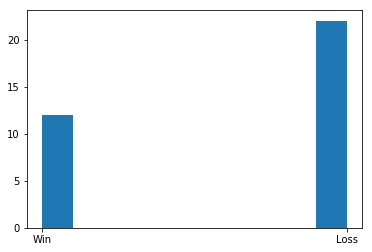

In [21]:
# Check the get_hist() function:

get_hist(teams_data['Nurnberg'])

In [22]:
# Instanitate an instance of our new MongodbHandler() class

db = MongodbHandler()

total wins:  8
total losses:  26
total wins:  20
total losses:  14
total wins:  7
total losses:  27
total wins:  8
total losses:  26
total wins:  18
total losses:  16
total wins:  9
total losses:  25
total wins:  10
total losses:  24
total wins:  5
total losses:  29
total wins:  16
total losses:  18
total wins:  10
total losses:  24
total wins:  8
total losses:  26
total wins:  10
total losses:  24
total wins:  17
total losses:  17
total wins:  14
total losses:  20
total wins:  12
total losses:  22
total wins:  6
total losses:  28
total wins:  17
total losses:  17
total wins:  20
total losses:  14
total wins:  25
total losses:  9
total wins:  8
total losses:  26
total wins:  11
total losses:  23
total wins:  7
total losses:  27
total wins:  15
total losses:  19
total wins:  8
total losses:  26
total wins:  12
total losses:  22
total wins:  9
total losses:  25
total wins:  23
total losses:  11
total wins:  13
total losses:  21
total wins:  10
total losses:  24
total wins:  20
total loss

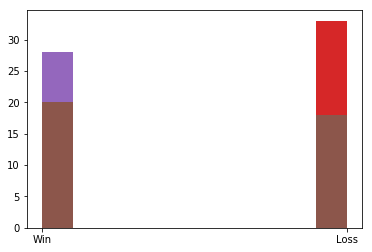

In [23]:
# Final Step: add everything to mongoDB!

# You could also write this into a callable function if you prefer

for team_name, data in tqdm(teams_data.items()):
    if data['rain_wins_2011'] == 0 and data['rain_losses_2011'] == 0:
        rain_win_pct = "N/A"
    else:
        total_rain_games = data['rain_wins_2011'] + data['rain_losses_2011']
        rain_win_pct = str(data['rain_wins_2011'] / total_rain_games)
    
    viz = get_hist(data)
    
    record = db.format_data(team_name, data['total_goals_2011'], data['total_wins_2011'], viz[0].tolist(), rain_win_pct)
#     print(record)
    db.insert_record(record)
    
    # delete viz object, so that a new one is created each time. 
    # Otherwise, it will just keep updating the first one instead
    # of creating new correct visualizations
    del(viz)
    

In [24]:
## Uncomment below if you wish to visualize the newly populated database:

# query_1 = db.coll.find({})
# for x in query_1:
#     print(x)

In [25]:
## Uncomment and run if you wish to re-populate your collection

# db.coll.drop()

# BACK TO VISUALIZATION FROM "ARRAY"

### So... we stored our histogram as an array... and now we want to get it back into a histogram:

#### Let's test things out for just one team instance:

I like Chelsea, so here we go:

In [26]:
# One team's values:

teams_data['Chelsea']

{'total_matches_2011': 38,
 'total_wins_2011': 18,
 'total_losses_2011': 20,
 'rain_wins_2011': 4,
 'rain_losses_2011': 14,
 'total_goals_2011': 65}

#### Now, we want to see exactly what's happening inside the `get_hist()` function:

total wins:  18
total losses:  20


(array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

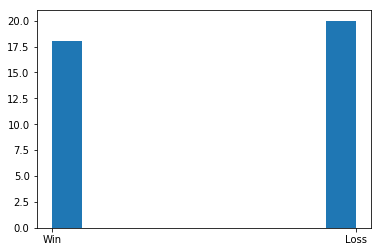

In [27]:
# Here, I took the contents of the function and instantiated the requirements individually:

# I want to see what the contents of this list are once it's populated

expanded_wl_data = []

print('total wins: ', teams_data['Chelsea']['total_wins_2011'])
print('total losses: ', teams_data['Chelsea']['total_losses_2011'])

# Append all the wins and losses accordingly
for i in range(teams_data['Chelsea']['total_wins_2011']):
    expanded_wl_data.append('Win')
for i in range(teams_data['Chelsea']['total_losses_2011']):
    expanded_wl_data.append('Loss')
    
# define the histogram    
hist = plt.hist(expanded_wl_data)


# Call the hist variable. 
# If you do this in a separate cell, you will not see the histogram (which confirm your wins and losses)

hist

In [28]:
# This is what I mean... no graph for some reason... 
# still uncertain why, but it doesn't really matter since the cell above does the
# job we require

hist

(array([18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [29]:
# Let's have a look at that list!

print(expanded_wl_data)

['Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss']


#### Time to define our new `back_to_viz()` function:

In [30]:
def back_to_viz(arr, query_here):
    viz_hist_count = []
    for x in range((int(arr[0]))):
        viz_hist_count.append('Loss')
    for x in range((int(arr[-1]))):
        viz_hist_count.append('Win')
    plt.hist(viz_hist_count) # You cannot call query_here['win_loss_histogram']
    plt.title(query_here['team_name']) # You can change the query accordingly
    return 

#### Get the Chelsea array from the mongodb:

(GO CHELSEA!)

In [31]:
query_CFC = db.coll.find_one({'team_name':'Chelsea'})

In [32]:
query_CFC

{'_id': ObjectId('5ce7f03f7ae53e512d7d3e9f'),
 'team_name': 'Chelsea',
 'goals_2011': 65,
 'wins_2011': 18,
 'win_loss_histogram': [18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0],
 'rain_win_pct': '0.16666666666666666'}

In [33]:
# Copy the array from above and define our new array variable:
array = query_CFC['win_loss_histogram']

# or you can copy and paste... if you're lazy lol
# array = [18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0]

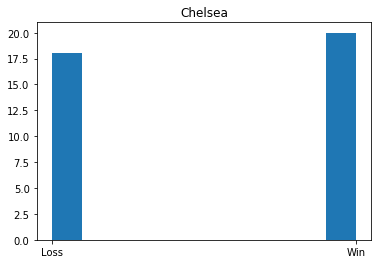

In [34]:
back_to_viz(array, query_CFC)

![Image of Yaktocat](https://worldsportlogos.com/wp-content/uploads/2018/01/Chelsea-logo.png)

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!